In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

%matplotlib inline

In [2]:
def source_data_from_directory(directory, image_size, validation_split, batch_size= 32, shuffle= True, seed = 0):
    train_dataset = image_dataset_from_directory(directory= directory,
                                             shuffle= shuffle,
                                             batch_size= batch_size,
                                             image_size=image_size,
                                             validation_split= validation_split,
                                             subset= "training",
                                             seed= seed)
    validation_dataset = image_dataset_from_directory(directory= directory,
                                                      shuffle= shuffle,
                                                      batch_size=batch_size,
                                                      image_size= image_size,
                                                      validation_split= validation_split,
                                                      subset= "validation",
                                                      seed= seed)
    return train_dataset, validation_dataset


In [3]:
DIRECTORY= "dataset/"
BATCH_SIZE= 32
IMAGE_SIZE= (160,160)

train_dataset, validation_dataset = source_data_from_directory(directory= DIRECTORY,
                                                               batch_size= BATCH_SIZE,
                                                               image_size= IMAGE_SIZE,
                                                               validation_split= 0.2,
                                                               seed= 42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


**let's take a look at our dataset**

In [4]:
def display_images(images, labels, class_names, fig_shape= (3,3), fig_size= (10,10)):
    height, width = fig_shape
    fig, ax = plt.subplots(height,width,figsize= fig_size)
    
    for i in range(height):
        for j in range(width):
            image = images[i*height + j]
            label = labels[i*height + j]
            
            ax[i,j].imshow(image/255)
            ax[i,j].set_title(class_names[label])
    plt.show()

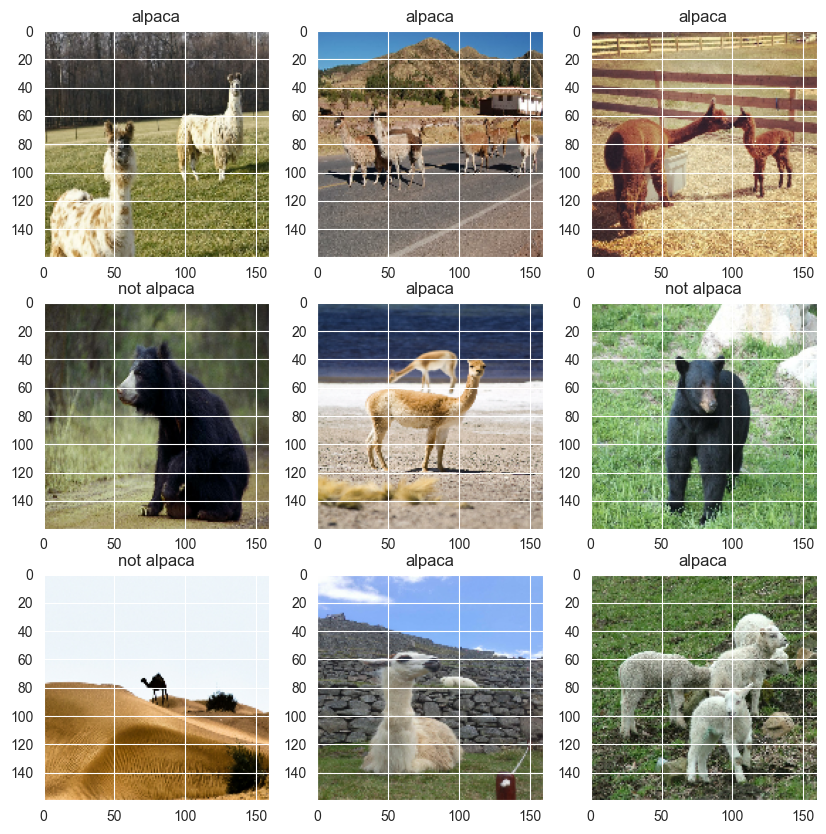

In [5]:
class_names = train_dataset.class_names
images, labels = next(iter(train_dataset.take(1)))

display_images(images, labels, class_names)

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset.prefetch(buffer_size= AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.2)
    ])
    return data_augmentation

In [8]:
def visualize_augmented_images(image, data_augmenter, fig_shape= (3,3), fig_size= (10,10)):
    height, width = fig_shape
    fig, ax = plt.subplots(height,width,figsize= fig_size)
    for i in range(height):
        for j in range(width):
            augmented_image = data_augmenter(image)[0]
            
            ax[i,j].imshow(augmented_image/255)
    plt.show()

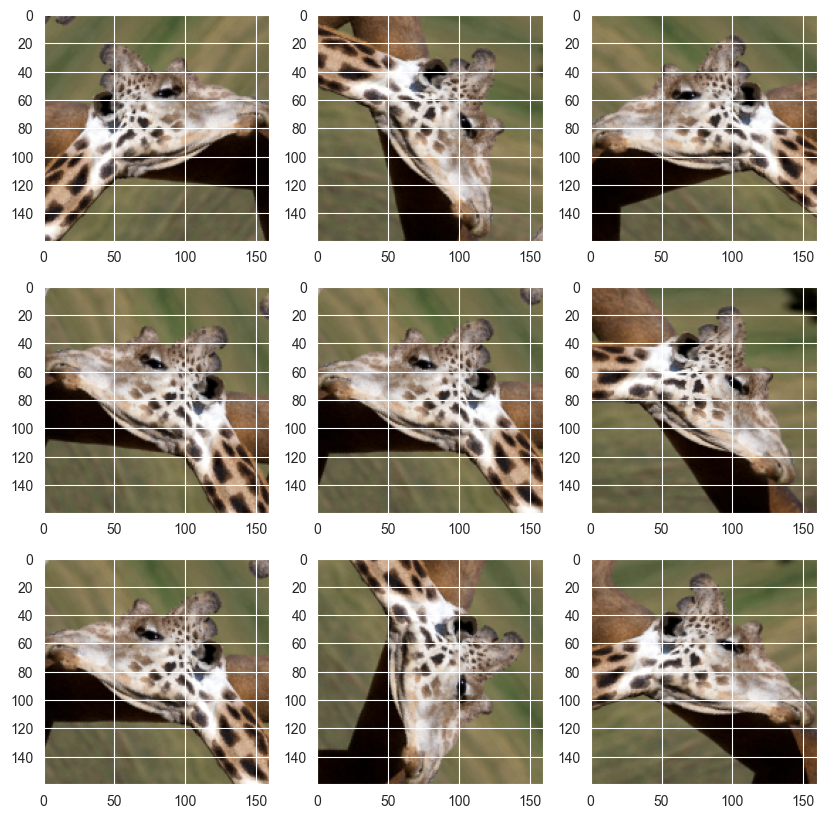

In [9]:
images, _ = next(iter(train_dataset.take(1)))
image = tf.expand_dims(images[0], 0)

visualize_augmented_images(image, data_augmenter())

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**just taking a look at the mobilenetV2 model**

In [11]:
model = tf.keras.applications.MobileNetV2(input_shape= (160,160,3),
                                          include_top= True,
                                          weights= "imagenet")
model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
def prepare_mobilenet_model(fine_tuning_layer, input_shape):
    model = tf.keras.applications.MobileNetV2(input_shape= input_shape, include_top=False, weights= "imagenet")
    model.trainable= True
    for layer in model.layers[:fine_tuning_layer]:
        layer.trainable = False
    return model

In [13]:
def create_mobilenet_based_model(input_shape, data_augmenter, preprocess, fine_tune_at = 120, classes = 1):
    inputs= tf.keras.Input(shape= input_shape)
    X = data_augmenter(inputs)
    X = preprocess(X)
    
    model = prepare_mobilenet_model(fine_tuning_layer= fine_tune_at, input_shape= input_shape)
    X = model(X, training= False)
    X = tfl.GlobalAveragePooling2D()(X)
    X = tfl.Dropout(0.2)(X)
    outputs = tfl.Dense(units= classes, activation= "linear")(X)
    
    result= tf.keras.Model(inputs, outputs)
    
    return result

In [14]:
input_shape= (160,160,3)

model = create_mobilenet_based_model(input_shape= input_shape,
                                     data_augmenter= data_augmenter(), 
                                     preprocess=preprocess_input,
                                     fine_tune_at= 120,
                                     classes= 1)

optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001)
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= ["accuracy"]
model.compile(optimizer= optimizer,
              loss= loss_function,
              metrics= metrics)

In [21]:
def plot_history(history):
    fig,ax = plt.subplots(2,1, figsize=(8,8), sharex= True)
    ax[0].plot(history["loss"], label= "training loss")
    ax[0].plot(history["val_loss"], label= "validation loss")
    ax[0].set_title("learning curve (loss)")
    ax[0].set_ylabel("loss")
    ax[0].set_xlabel("iterations")
    
    ax[1].plot(history["accuracy"], label= "training accuracy")
    ax[1].plot(history["val_accuracy"], label= "validation accuracy")
    ax[1].set_title("learning curve (accuracy)")
    ax[1].set_ylabel("accuracy")
    ax[1].set_xlabel("iterations")
    
    plt.legend()
    plt.show()

In [16]:
history= model.fit(train_dataset,
                   validation_data= validation_dataset,
                   epochs= 10,
                   )

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5330 - loss: 0.7239 - val_accuracy: 0.8154 - val_loss: 0.3736
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7318 - loss: 0.4518 - val_accuracy: 0.9385 - val_loss: 0.2258
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8708 - loss: 0.2792 - val_accuracy: 0.9538 - val_loss: 0.1656
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9050 - loss: 0.2310 - val_accuracy: 0.9692 - val_loss: 0.1324
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9380 - loss: 0.1679 - val_accuracy: 0.9846 - val_loss: 0.1062
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9509 - loss: 0.1090 - val_accuracy: 0.9846 - val_loss: 0.0951
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9723 - loss: 0.0998 - val_accuracy: 0.9846 - val_loss: 0.0773
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9777 - loss: 0.0853 - val_accuracy: 0.9846 - val_loss: 0.0822
Epoch 9/10

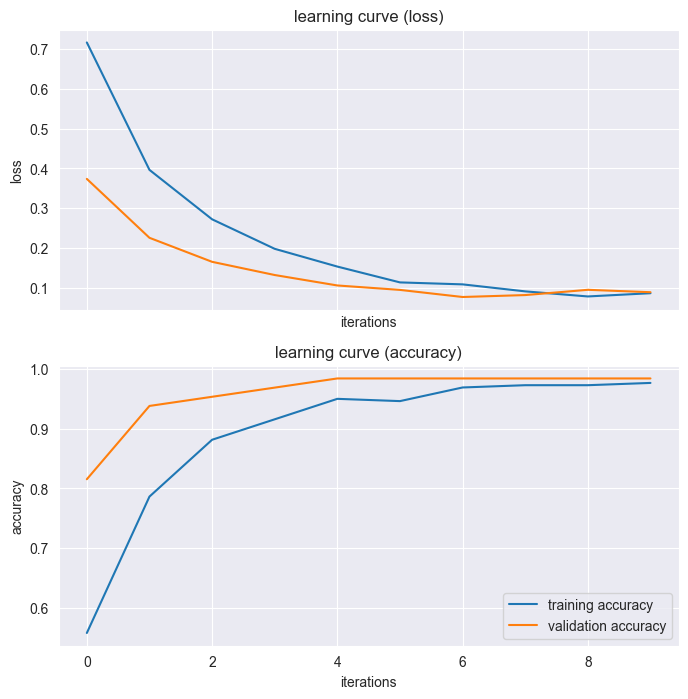

In [22]:
plot_history(history.history)

In [20]:
train_loss, train_accuracy = model.evaluate(train_dataset)
val_loss, val_accuracy = model.evaluate(validation_dataset)

print(f"train_accuracy= {train_accuracy*100:.2f}%, validation accuracy= {val_accuracy*100:.2f}%")
print(f"train loss= {train_loss:.2f}, validation loss= {val_loss:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 870ms/step - accuracy: 0.9860 - loss: 0.0711
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.9884 - loss: 0.0782
train_accuracy= 98.47%, validation accuracy= 98.46%
train loss= 0.06, validation loss= 0.09
